In [1]:
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import classification_report

In [5]:
path_to_train='Train/'
path_to_valid = 'Valid/'
path_to_test='Test/'

In [6]:
X_train=np.load(path_to_train+"X_train.npy")
X_valid=np.load(path_to_valid+"X_valid.npy")

In [7]:
y_train_superclass=np.load(path_to_train+"y_train_binary.npy")
y_valid_superclass=np.load(path_to_valid+"y_valid_binary.npy")

In [8]:
batch_size = 128

In [9]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train_superclass)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

X_valid_tensor = torch.Tensor(X_valid)
y_valid_tensor = torch.LongTensor(y_valid_superclass)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)

In [10]:
X_test=np.load(path_to_test+"X_test.npy")
y_test=np.load(path_to_test+"y_test_binary.npy")

In [11]:
del X_train
del X_valid

del y_train_superclass
del y_valid_superclass

del X_train_tensor
del y_train_tensor

del X_valid_tensor
del y_valid_tensor

In [12]:
def train(epoch,my_model, data_loader, optimizer, loss_function):
    losses=[]
    my_model.train()
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        output = my_model(X_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X_batch), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
        losses.append(loss.data.numpy())
    return np.mean(losses)

In [13]:
def test(my_model, data_loader, loss_function):
    accuracy_arr = []
    my_model.eval()
    test_loss = 0
    correct = 0
    for X_batch, y_batch in data_loader:
        output = my_model(X_batch)
        test_loss += loss_function(output, y_batch).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y_batch.data.view_as(pred)).cpu().sum()

    test_loss /= len(data_loader)
    acc = correct / len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return acc,test_loss

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

def print_confusion_matrix(model, X, y):
    model.eval()
    y_pred = model(torch.Tensor(X)).data.numpy().argmax(axis = 1)
    print(confusion_matrix(y, y_pred))
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy = {accuracy}")
    return accuracy

In [15]:
def training(number_of_epoches, model, optimizer, loss_function, learning_rate, train_loader, valid_loader):
    loss_train=[]
    loss_valid=[]
    acc=[]
    best_accuracy, last_accuracy = 0, 0
    patience = 3
    trigger_times = 0 
    
    for epoch in range(number_of_epoches):
        loss_train.append(train(epoch + 1,model, train_loader, optimizer, loss_function))
        accuracy, current_loss = test(model, valid_loader, loss_function)
        acc.append(accuracy)
        loss_valid.append(current_loss)
        if accuracy < last_accuracy:
            trigger_times += 1
            if trigger_times > patience:
                break
        else:
            trigger_times = 0  
        if epoch ==int(number_of_epoches * 0.3):
            optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)    
        print("Trigger times", trigger_times) 
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        last_accuracy = accuracy
        
    return loss_train, loss_valid, acc

In [16]:
loss_function=nn.CrossEntropyLoss()

In [17]:
learning_rate = 0.001
learning_rate_2 = 0.0001

In [18]:
input_shape=1000

In [19]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1):
        super().__init__()

        self.model = nn.Sequential(
        nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size[0], padding = kernel_size[0] //2, stride = stride),
        nn.BatchNorm1d(out_channels),  nn.LeakyReLU(0.01),
        nn.Conv1d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size[1], padding = kernel_size[1] // 2),
            
        )
        self.leakyReLU = nn.LeakyReLU(0.01)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size = 1, stride = stride)
            )
        self.bn = nn.BatchNorm1d(out_channels)

        
    def forward(self, X):
        output = self.model(X)
        output += self.shortcut(X)
        output = self.bn(output)
        output = self.leakyReLU(output)

        return output

In [20]:
class CNN_ResNet(nn.Module):
    def __init__(self,in_channels,  input_shape, n_outputs, block, kernel_size = [3,3,3,5,5]):
        super().__init__()
        self.zero = nn.ZeroPad2d(3)
        self.conv1D_1 = nn.Conv1d(in_channels = in_channels+6, out_channels = 64, kernel_size =  kernel_size[0], padding = 'same')
        self.bn_1 = nn.BatchNorm1d(64)
        self.leakyReLU_1 = nn.LeakyReLU(0.01)
        self.maxpool = nn.MaxPool1d(2)
        self.conv1D_2 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = kernel_size[1], padding = 'same')
        self.bn_2 = nn.BatchNorm1d(64)
        self.leakyReLU_2 = nn.LeakyReLU(0.01)
    
        self.block1 = self.make_layer(block, 64, 64, kernel_size[1:3], 2)
        self.block2 = self.make_layer(block, 64, 64, kernel_size[3:5], 2)
        self.maxpool2 = nn.MaxPool1d(2)
        


        
        self.adAvgPooling = nn.AdaptiveAvgPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2 * 64,n_outputs)
        self.bn = nn.BatchNorm1d(n_outputs)
        self.softmax = nn.Softmax(dim=1)

    def make_layer(self, block, in_channels, out_channels, kernel_size, stride = 1):  
        return nn.Sequential(block(in_channels, out_channels, kernel_size, stride))

    def forward(self, x):
        
        output = self.zero(x)
        output = self.conv1D_1(output)
        output = self.bn_1(output)
        output = self.leakyReLU_1(output)
        output = self.maxpool(output)
  

        output = self.block1(output)
        output = self.block2(output) 
        output = self.maxpool2(output)
        
        output = self.adAvgPooling(output)
        output = self.flatten(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.softmax(output)
        return output

In [21]:
model = CNN_ResNet(12, 1000, 2, BasicBlock, [5,5,5,5,5])

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [23]:
loss_train, loss_valid, accuracy = training(30, model, optimizer, loss_function, learning_rate_2, train_loader, valid_loader)

Train Epoch: 1 [0/12069 (0%)]	Loss: 0.637057
Train Epoch: 1 [1280/12069 (11%)]	Loss: 0.514830
Train Epoch: 1 [2560/12069 (21%)]	Loss: 0.514751
Train Epoch: 1 [3840/12069 (32%)]	Loss: 0.495268
Train Epoch: 1 [5120/12069 (42%)]	Loss: 0.484821
Train Epoch: 1 [6400/12069 (53%)]	Loss: 0.468500
Train Epoch: 1 [7680/12069 (63%)]	Loss: 0.470574
Train Epoch: 1 [8960/12069 (74%)]	Loss: 0.444633
Train Epoch: 1 [10240/12069 (84%)]	Loss: 0.469088
Train Epoch: 1 [11520/12069 (95%)]	Loss: 0.469226

Test set: Average loss: 0.4776, Accuracy: 2229/2587 (86.16%)

Trigger times 0
Train Epoch: 2 [0/12069 (0%)]	Loss: 0.434640
Train Epoch: 2 [1280/12069 (11%)]	Loss: 0.462658
Train Epoch: 2 [2560/12069 (21%)]	Loss: 0.444147
Train Epoch: 2 [3840/12069 (32%)]	Loss: 0.455178
Train Epoch: 2 [5120/12069 (42%)]	Loss: 0.460545
Train Epoch: 2 [6400/12069 (53%)]	Loss: 0.446246
Train Epoch: 2 [7680/12069 (63%)]	Loss: 0.467883
Train Epoch: 2 [8960/12069 (74%)]	Loss: 0.455619
Train Epoch: 2 [10240/12069 (84%)]	Loss: 0.45

Train Epoch: 15 [6400/12069 (53%)]	Loss: 0.381867
Train Epoch: 15 [7680/12069 (63%)]	Loss: 0.367563
Train Epoch: 15 [8960/12069 (74%)]	Loss: 0.418726
Train Epoch: 15 [10240/12069 (84%)]	Loss: 0.372153
Train Epoch: 15 [11520/12069 (95%)]	Loss: 0.364852

Test set: Average loss: 0.4191, Accuracy: 2341/2587 (90.49%)

Trigger times 3
Train Epoch: 16 [0/12069 (0%)]	Loss: 0.356789
Train Epoch: 16 [1280/12069 (11%)]	Loss: 0.360054
Train Epoch: 16 [2560/12069 (21%)]	Loss: 0.372800
Train Epoch: 16 [3840/12069 (32%)]	Loss: 0.360249
Train Epoch: 16 [5120/12069 (42%)]	Loss: 0.364721
Train Epoch: 16 [6400/12069 (53%)]	Loss: 0.375694
Train Epoch: 16 [7680/12069 (63%)]	Loss: 0.375943
Train Epoch: 16 [8960/12069 (74%)]	Loss: 0.364923
Train Epoch: 16 [10240/12069 (84%)]	Loss: 0.390993
Train Epoch: 16 [11520/12069 (95%)]	Loss: 0.396520

Test set: Average loss: 0.4206, Accuracy: 2329/2587 (90.03%)



In [24]:
print_confusion_matrix(model, X_test, y_test)

[[1354  184]
 [  97  951]]
Accuracy = 0.891337973704563


0.891337973704563

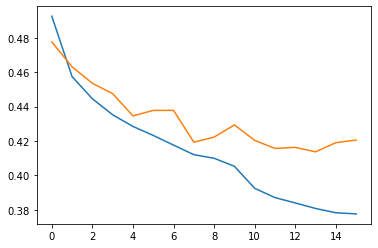

In [25]:
plt.plot(loss_train, label = 'Train Loss')
plt.plot(loss_valid, label = 'Validation Loss')
plt.show()

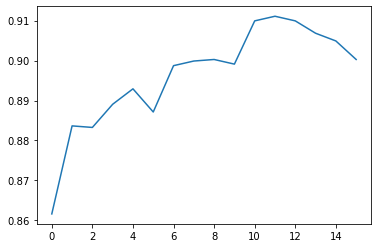

In [26]:
plt.plot(accuracy)
plt.show()

In [27]:
print("Best accuracy: ",np.max(accuracy)," Epoch: ", np.argmax(accuracy)+1)

Best accuracy:  0.91109395  Epoch:  12


In [28]:
model.eval()
y_pred = model(torch.Tensor(X_test)).data.numpy().argmax(axis = 1)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1538
           1       0.84      0.91      0.87      1048

    accuracy                           0.89      2586
   macro avg       0.89      0.89      0.89      2586
weighted avg       0.89      0.89      0.89      2586



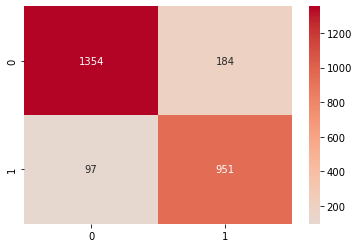

In [30]:
cm = confusion_matrix(y_test,y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', center = 0)